In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
import networkx as nx
import random
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import eigh
from scipy.spatial import distance_matrix
from scipy.spatial import cKDTree
from numpy.linalg import lstsq
from scipy.spatial.distance import cdist



# Class implementation


In [321]:
EMBEDDING_DIM = 4

In [322]:
def compute_kernel_matrix(X, k):
    D = squareform(pdist(X))
    sig = np.median(np.sort(D, axis=1)[:, k])
    K = np.exp(-D ** 2 / sig ** 2)
    return K

def compute_laplacian(K):
    D_inv = np.diag(np.sum(K, axis=1) ** (-0.5))
    L = D_inv @ K @ D_inv
    return L

def compute_leading_eigenvectors(L, d):
    lam, v = np.linalg.eigh(L)
    sort_idx = np.argsort(lam)[::-1]
    return lam[sort_idx][:d], v[:, sort_idx][:, :d]

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return image, hsv

def detect_shapes(image):
    polygon_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    rectangles = []
    circles = []

    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 50])
    blue_lower = np.array([100, 150, 50])
    blue_upper = np.array([140, 255, 255])
    green_lower = np.array([40, 50, 50])
    green_upper = np.array([90, 255, 255])

    black_mask = cv2.inRange(image, black_lower, black_upper)
    contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(polygon_mask, [contour], -1, 255, thickness=cv2.FILLED)

    blue_mask = cv2.inRange(image, blue_lower, blue_upper)
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        rectangles.append((x, y, w, h))

    green_mask = cv2.inRange(image, green_lower, green_upper)
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        circles.append((int(x), int(y), int(radius)))

    return polygon_mask, rectangles, circles

def generate_random_points(mask, num_points=1000):
    points = []
    h, w = mask.shape
    while len(points) < num_points:
        x, y = random.randint(0, w - 1), random.randint(0, h - 1)
        if mask[y, x] == 255:
            points.append((x, y))
    return points

def build_graph(mask, rectangles):
    G = nx.grid_2d_graph(mask.shape[0], mask.shape[1])
    for x, y, w, h in rectangles:
        for i in range(x, x + w):
            for j in range(y, y + h):
                if (j, i) in G:
                    G.remove_node((j, i))
    return G

def compute_shortest_paths(G, points, circles):
    dist_matrix = np.zeros((len(points), len(circles))) # Renamed the variable
    for i, (px, py) in enumerate(points):
        for j, (cx, cy, _) in enumerate(circles):
            try:
                path_length = nx.shortest_path_length(G, (py, px), (cy, cx))
            except nx.NetworkXNoPath:
                path_length = float('inf')
            dist_matrix[i, j] = path_length # Use the new variable name
    return dist_matrix # Return the new variable name

In [335]:
# ====================================
# Area - create G^A
# ====================================

class PhysicalLayoutGraph:
    def __init__(self, image_path, num_points=500, embedding_dim=EMBEDDING_DIM, k=7):
        self.image_path = image_path
        self.num_points = num_points
        self.embedding_dim = embedding_dim
        self.k = k
        self._process_image()
        self._compute_adjacency()
        self._compute_embedding()
        self.dist_matrix = None

    def _process_image(self):
        image, gray = load_image(self.image_path)
        self.image = image
        self.gray = gray
        self.polygon_mask, self.rectangles, self.circles = detect_shapes(gray)

        self.G = build_graph(self.polygon_mask, self.rectangles)
        self.random_points = generate_random_points(self.polygon_mask, num_points=self.num_points)
        self.random_points = np.array(self.random_points)
        #self.df_points_with_signals = {'x': random_points_from_graph[:, 0], 'y': random_points_from_graph[:, 1]}

    def _compute_adjacency(self):
        self.kernel_matrix = compute_kernel_matrix(self.random_points, k=self.k)

    def _compute_embedding(self):
        L = compute_laplacian(self.kernel_matrix)
        print(self.embedding_dim + 1)
        lam, v = compute_leading_eigenvectors(L, self.embedding_dim + 1)
        self.embedding = v[:, 1:self.embedding_dim + 1]

    def get_embedding(self):
        return self.embedding

    def get_points(self):
        return self.random_points

    def plot_embedding(self):
        plt.figure(figsize=(6, 6))
        plt.scatter(self.embedding[:, 0], self.embedding[:, 1])
        plt.title("Physical Layout Spectral Embedding")
        plt.show()

    def plot_on_layout(self, predicted_points, true_points, title="Predicted Layout Locations"):
      plt.figure(figsize=(8, 8))
      plt.imshow(self.polygon_mask, cmap='gray', alpha=0.5)
      plt.imshow(self.image, alpha=0.3)

      predicted_p = np.array(predicted_points)
      plt.scatter(predicted_p[:, 0], predicted_p[:, 1], color='red', s=50, label="Predicted Points")

      true_p = np.array(true_points)
      plt.scatter(true_p[:, 0], true_p[:, 1], color='green', s=50, label="True Points")

      plt.legend()
      plt.title(title)
      plt.show()

    def embedding_to_layout_xy(self, embedding_points):
        """
        Maps points from embedding space to nearest real (x,y) layout points.
        """
        # Build KDTree of embedding
        tree = cKDTree(self.embedding)

        # Find nearest neighbor indices
        dists, indices = tree.query(embedding_points)

        # Map to (X, Y) points
        real_points = np.array(self.random_points)[indices]

        return real_points


In [546]:
# ====================================
# SignalGraph - G^S
# ====================================

class SignalGraph:
    def __init__(self, signal_data, embedding_dim=EMBEDDING_DIM, k_nearest=1):
        self.signal_data = signal_data
        self.embedding_dim = embedding_dim
        self.k_nearest = k_nearest
        self._build_kernel()
        self._compute_embedding()

    def _build_kernel(self):
        self.kernel_matrix = compute_kernel_matrix(self.signal_data, k=self.k_nearest)

    def _compute_embedding(self):
        L = compute_laplacian(self.kernel_matrix)
        lam, v = compute_leading_eigenvectors(L, self.embedding_dim + 1)
        self.embedding = v[:, 1:self.embedding_dim + 1]

    def get_embedding(self):
        return self.embedding

    def plot_embedding(self):
        plt.figure(figsize=(6, 6))
        plt.scatter(self.embedding[:, 0], self.embedding[:, 1])
        plt.title("Signal Graph Spectral Embedding")
        plt.show()



In [ ]:
class ManifoldMatcherSSL:
    def __init__(self):
        self.fitted = False
        self.layout_graph = None
        self.signal_graph = None
        self.aligned_signal_embedding = None
        self.labeled_indices = None 

    def fit(self, layout_graph, signal_graph, labeled_indices):
        """
        Calibrate layout to signal space using SSL-style least squares.
        """
        self.layout_graph = layout_graph
        self.signal_graph = signal_graph

        layout_embedding = layout_graph.get_embedding()
        signal_embedding = signal_graph.get_embedding()

        self.layout_embedding = layout_embedding
        self.signal_embedding = signal_embedding

        # phi_A = layout_embedding[labeled_indices]
        phi_S = signal_embedding[labeled_indices]

        #centered
        A_all = np.array(self.layout_graph.get_points())
        self.A_mean = A_all.mean(axis=0, keepdims=True)  
        A_labeled = A_all[labeled_indices]
        centered_A = A_labeled - self.A_mean

        self.C, _, _, _ = np.linalg.lstsq( phi_S, centered_A, rcond=None)
        print(f"phi_S_dim :{phi_S.shape}, A_dim:{centered_A.shape}, C dim {self.C.shape}, ")
        print(self.C)
        A_all_centered = A_all - self.A_mean
        self.calibrated_phi_s = phi_S  @ self.C
        self.fitted = True
        return phi_S, centered_A, self.C, self.calibrated_phi_s

    def predict(self, new_signal_vectors, validation_indices):
        """
        Predict layout locations for new signal vectors (not embeddings).
        Uses 1-NN matching in calibrated spectral space.
        """
        if not self.fitted:
            raise ValueError("Must call .fit() before .predict()")
        # self.calibrated_phi_s = self.calibrated_phi_s + self.A_mean
        self.calibrated_phi_s = self.signal_embedding[validation_indices] @ self.C
        return self.calibrated_phi_s + self.A_mean

 


# Build G_a G_s

In [547]:
def calc_signals():
  image_path = 'C:\\Users\\Noa\\Documents\\Thesis\\data\\floor_plan_c.png'

  # Build G^A
  layout_graph = PhysicalLayoutGraph(image_path, num_points=500, embedding_dim=4, k=1)
  layout_graph.dist_matrix = compute_shortest_paths(layout_graph.G, layout_graph.random_points, layout_graph.circles)
  num_circles = layout_graph.dist_matrix.shape[1]  # Get the number of circles
  print(f"Number of circles: {num_circles}")
  signals = np.zeros_like(layout_graph.dist_matrix)  # Initialize signals array

  for i in range(num_circles):
    signals[:, i] = np.log(1 / (layout_graph.dist_matrix[:, i]**2 + 1e-10))
    
  return signals, layout_graph

In [548]:
def merge_signals_points(signals, random_points_from_graph):
  df_data = {
        'x': random_points_from_graph[:, 0],
        'y': random_points_from_graph[:, 1]}
  # Add signal columns
  for i in range(signals.shape[1]):
      df_data[f'signal_{i+1}'] = signals[:, i]

  points_with_signals_df = pd.DataFrame(df_data)
  return points_with_signals_df

In [549]:
signals, area_graph = calc_signals()

5
Number of circles: 9


In [550]:
points_with_signals_df = merge_signals_points(signals,area_graph.random_points)

In [551]:
points_with_signals_df

,x,y,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9
0,22,80,-9.672564,-7.657283,-10.318111,-10.408013,-6.089045,-10.858691,-8.713418,-9.795680,-10.832201
1,181,62,-9.868948,-10.626412,-8.525360,-7.427144,-10.576534,-8.348775,-10.684669,-10.606610,-9.608042
2,155,40,-9.810550,-10.586610,-9.345658,-9.307921,-10.535716,-8.014666,-10.162809,-10.060876,-7.902487
3,154,94,-8.954674,-10.247928,-6.664409,-8.120886,-10.235988,-9.640563,-10.731952,-10.655752,-9.750395
4,12,50,-10.223976,-9.400961,-10.731952,-10.805355,-7.783641,-10.675076,-6.664409,-8.496990,-10.646020
...,...,...,...,...,...,...,...,...,...,...,...
495,89,28,-9.419060,-9.953467,-10.137808,-10.235988,-9.883285,-9.780698,-9.345658,-9.190240,-9.735069
496,100,86,-7.475339,-9.400961,-9.249946,-9.400961,-9.307921,-10.099712,-10.047761,-9.939627,-10.060876
497,45,79,-9.288782,-7.824046,-10.047761,-10.150348,-7.613325,-10.636240,-9.210340,-9.608042,-10.606610
498,124,97,-7.700295,-9.810550,-8.837681,-9.149422,-9.883285,-9.925689,-10.462217,-10.374772,-9.883285


In [552]:
labeled_indices = [i for i in range(100)]

In [553]:
signal_graph = SignalGraph(signals, embedding_dim=EMBEDDING_DIM, k_nearest=7)

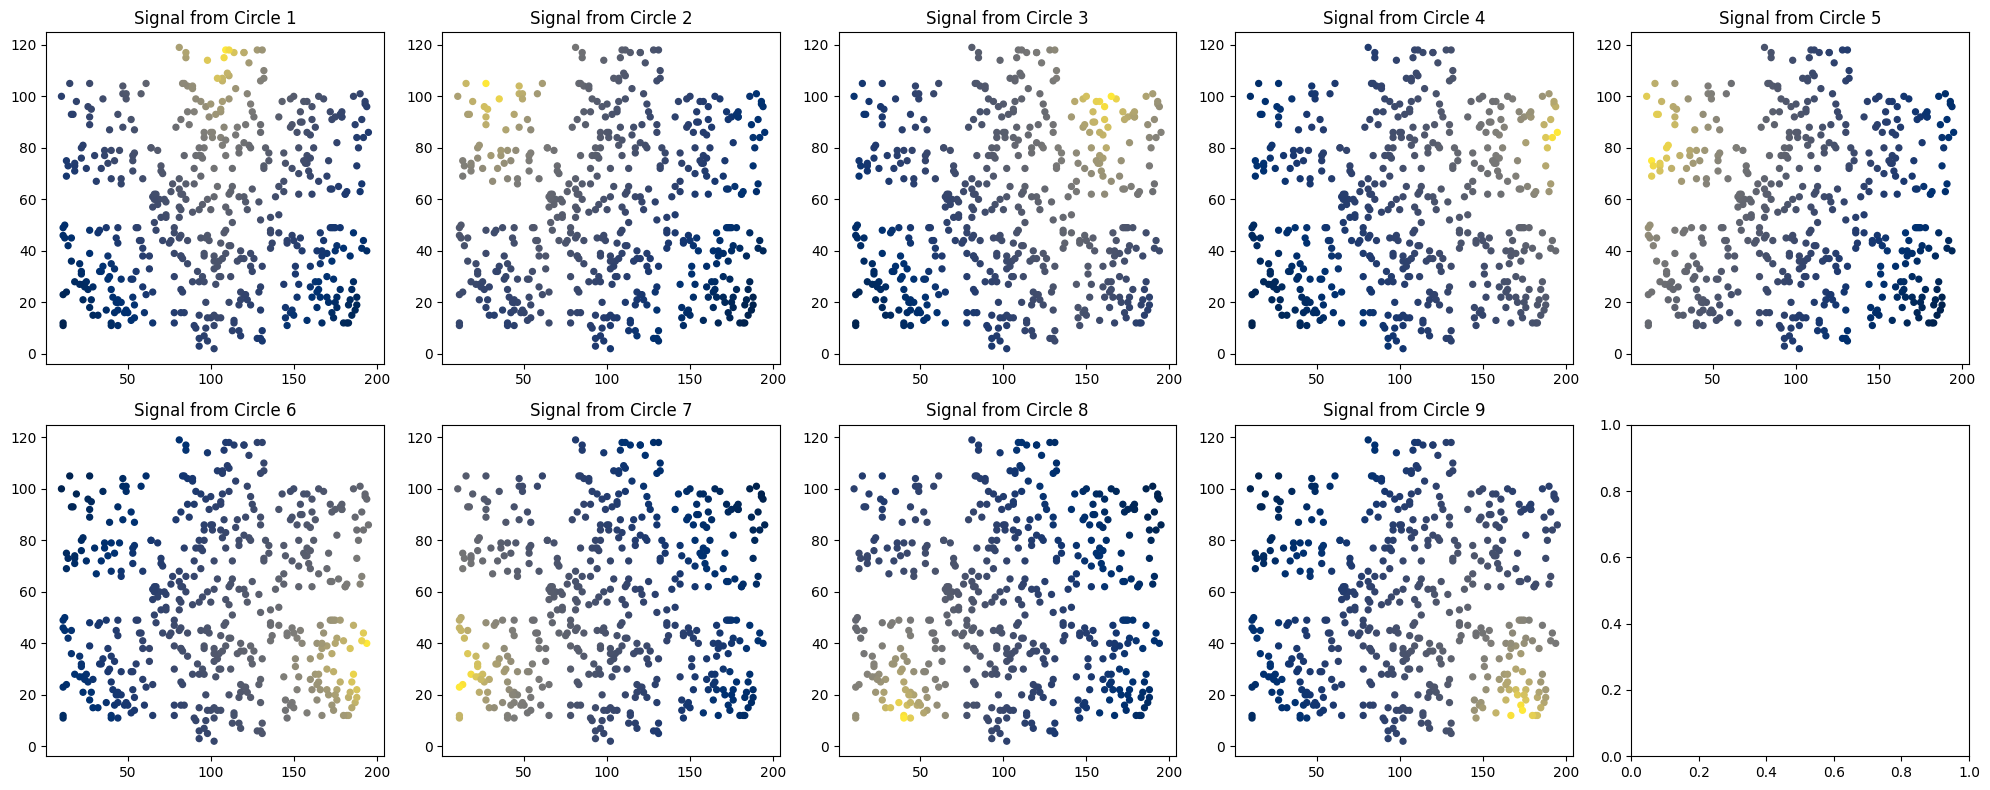

In [554]:
# Get the random points from the area_graph object
random_points_from_A = area_graph.get_points()

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()[:9]):
    ax.scatter(random_points_from_A[:, 0], random_points_from_A[:, 1],
               c=np.log(1 / (area_graph.dist_matrix[:, i]**2)), s=18, cmap='cividis')
    ax.set_title(f'Signal from Circle {i+1}')

plt.tight_layout()
plt.show()

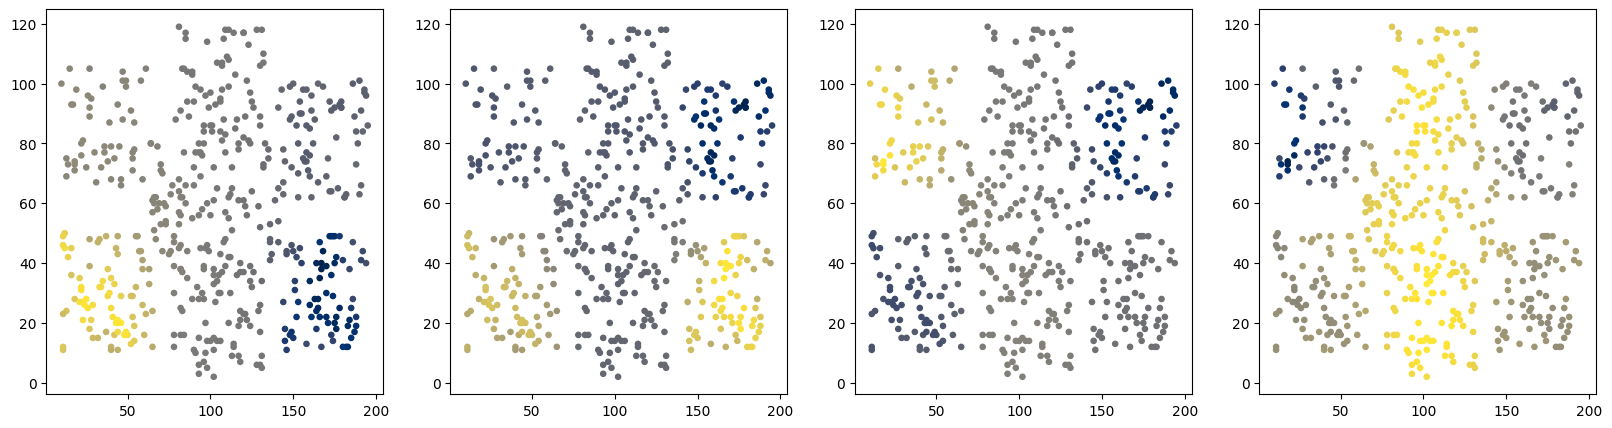

In [555]:
fig,axs = plt.subplots(1,4,figsize = (20,5))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(random_points_from_A[:,0],random_points_from_A[:,1],c = signal_graph.embedding[:,i],s = 14,cmap = 'cividis')


# Matching

In [556]:
# Assuming you have already run the cells to create:
# - area_graph (PhysicalLayoutGraph built on all random_points)
# - signals (np.ndarray of signals for all random_points)
# - signal_graph (SignalGraph built on all signals)
# - points_with_signals_df (pd.DataFrame combining random_points and signals)

# Define labeled indices
labeled_indices = [i for i in range(100)] # Use the first 20 points for fitting

# Initialize and fit the matcher using the pre-built graphs and labeled indices
matcher = ManifoldMatcherSSL()
phi_s, centered_A, C, calib_phi_s = matcher.fit(area_graph, signal_graph, labeled_indices)

phi_S_dim :(100, 4), A_dim:(100, 2), C dim (4, 2), 
[[-982.4932132   -57.99582997]
 [-127.48893268 -425.08322128]
 [-481.52637518   32.28656644]
 [ 117.43617533 -173.13672129]]


In [557]:
calib_phi_s

array([[-8.31641559e+01,  3.65410539e+01],
       [ 5.79601416e+01,  3.12452142e+01],
       [ 5.42292074e+01, -1.91027915e+01],
       [ 6.44089924e+01,  3.46281271e+01],
       [-7.44959529e+01, -2.68832052e+01],
       [-6.06523380e+01, -2.13368601e+01],
       [ 1.12958222e+00, -2.32188318e+00],
       [ 8.23990571e-01, -2.28929485e+00],
       [ 2.78428167e+00,  3.14882156e+00],
       [ 4.25212702e+00,  3.63267346e+00],
       [ 1.30406580e+01,  6.51139271e+00],
       [ 7.29927083e+01, -2.84634299e+01],
       [-2.06330488e+01, -2.14902943e+00],
       [ 4.30928449e+00,  2.18641399e+00],
       [-4.74123124e+01,  1.75480579e+01],
       [ 4.89041571e+00,  2.75762684e+00],
       [ 7.42884697e+01, -2.89048794e+01],
       [ 4.90588614e+00,  2.81093700e+00],
       [-7.31082386e-01, -8.56852203e-01],
       [-4.15714260e-03, -2.36409597e+00],
       [-1.31739009e+01, -1.75277077e+00],
       [ 7.06336940e+01, -2.67138417e+01],
       [ 1.65602230e+00, -1.87415422e+00],
       [ 6.

In [558]:
phi_s.shape

(100, 4)

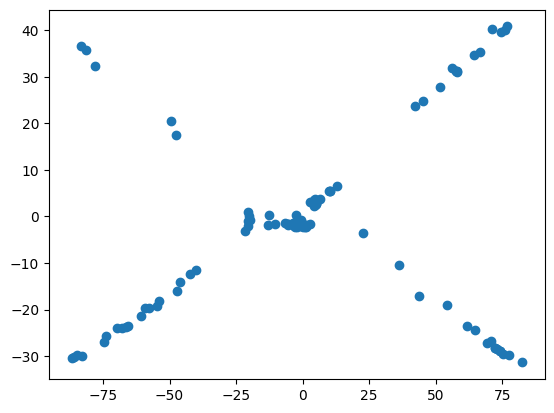

In [559]:
plt.scatter(phi_s @ C[:,0], phi_s @ C[:,1]) 

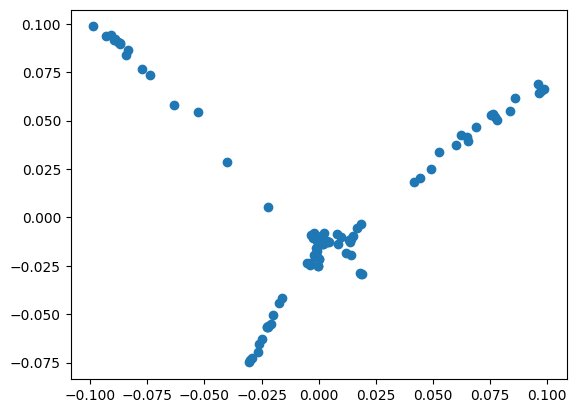

In [560]:
plt.scatter(phi_s[:,0], phi_s[:,1]) 

In [561]:
# Define validation indices (e.g., indices from 20 to 29)
# Make sure these indices are not in labeled_indices
validation_indices = list(range(100, 150))

# Important: Add a check to ensure validation_indices do not overlap with labeled_indices
if any(i in labeled_indices for i in validation_indices):
    raise ValueError("Validation indices overlap with labeled indices.")

# Extract signal data and true layout locations for validation points
validation_data = points_with_signals_df.iloc[validation_indices].copy()
validation_signal_data = validation_data.drop(['x', 'y'], axis=1).values
validation_true_real_locations = validation_data[['x', 'y']].values

In [562]:
validation_signal_data.shape

(50, 9)

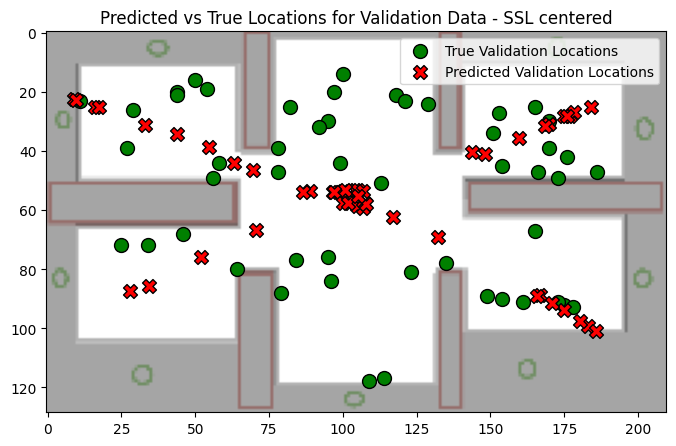

In [563]:
# Predict locations for the validation signal data
predicted_locations_validation = matcher.predict(validation_signal_data, validation_indices)

# Plot the predicted and true locations for the validation data on the layout
plt.figure(figsize=(8, 8))
plt.imshow(area_graph.polygon_mask, cmap='gray', alpha=0.5)
plt.imshow(area_graph.image, alpha=0.3)

# Plot the true locations of the validation points
plt.scatter(validation_true_real_locations[:, 0], validation_true_real_locations[:, 1], color='green', s=100, label="True Validation Locations", marker='o', edgecolor='black')

# Plot the predicted locations of the validation points
plt.scatter(predicted_locations_validation[:, 0], predicted_locations_validation[:, 1], color='red', s=100, label="Predicted Validation Locations", marker='X', edgecolor='black')

plt.legend()
plt.title("Predicted vs True Locations for Validation Data - SSL centered")
plt.show()

# SSL MATCH

In [579]:
class SSLMatcher:
    def __init__(self):
        self.fitted = False
        self.layout_graph = None
        self.signal_graph = None
        self.aligned_signal_embedding = None
        self.labeled_indices = None 

    def fit(self, layout_graph, signal_graph, labeled_indices):
        """
        Calibrate layout to signal space using SSL-style least squares.
        """
        self.layout_graph = layout_graph
        self.signal_graph = signal_graph

        layout_embedding = layout_graph.get_embedding()
        signal_embedding = signal_graph.get_embedding()

        self.layout_embedding = layout_embedding
        self.signal_embedding = signal_embedding

        # phi_A = layout_embedding[labeled_indices]
        phi_S = signal_embedding[labeled_indices]

        #centered
        A_all = np.array(self.layout_graph.get_points())
        self.A_mean = A_all.mean(axis=0, keepdims=True)  
        A_labeled = A_all[labeled_indices]
        centered_A = A_labeled - self.A_mean

        self.C, _, _, _ = np.linalg.lstsq(centered_A, phi_S, rcond=None)
        print(f"phi_S_dim :{phi_S.shape}, A_dim:{centered_A.shape}, C dim {self.C.shape}, ")
        print(self.C)
        A_all_centered = A_all - self.A_mean
        self.calibrated_phi_s = phi_S  @ self.C.T
        self.fitted = True
        return phi_S, centered_A, self.C, self.calibrated_phi_s

    def predict(self, new_signal_vectors):
        """
        Predict (x, y) locations for new signal vectors using layout-to-signal calibration.

        This uses kernel projection of new signals into signal embedding space,
        then finds the nearest layout point by comparing to projected layout embeddings.
        """
        if not self.fitted:
            raise ValueError("Must call .fit() before .predict()")

        # 1. Embed new signal vectors using kernel projection
        raw_signal_data = self.signal_graph.signal_data
        signal_embedding_all = self.signal_graph.get_embedding()

        D = cdist(new_signal_vectors, raw_signal_data)
        sigma = np.median(np.sort(D, axis=1)[:, self.signal_graph.k_nearest - 1])
        K = np.exp(-D**2 / sigma**2)
        new_signal_embedded = (K @ signal_embedding_all) / K.sum(axis=1, keepdims=True)

        # 2. Project layout points into the signal embedding space using learned C
        A_all = np.array(self.layout_graph.get_points())
        A_all_centered = A_all - self.A_mean
        projected_layout_signals = A_all_centered @ self.C  # shape: (n_layout, d)

        # 3. For each embedded signal, find the nearest projected layout signal
        distances = cdist(new_signal_embedded, projected_layout_signals)
        nearest_indices = np.argmin(distances, axis=1)

        # 4. Return the corresponding real-world (x, y) layout points
        predicted_xy = A_all[nearest_indices]
        return predicted_xy

 

In [580]:
# Assuming you have already run the cells to create:
# - area_graph (PhysicalLayoutGraph built on all random_points)
# - signals (np.ndarray of signals for all random_points)
# - signal_graph (SignalGraph built on all signals)
# - points_with_signals_df (pd.DataFrame combining random_points and signals)

# Define labeled indices
labeled_indices = [i for i in range(100)] # Use the first 20 points for fitting

# Initialize and fit the matcher using the pre-built graphs and labeled indices
matcher = SSLMatcher()
phi_s, centered_A, C, calib_phi_s = matcher.fit(area_graph, signal_graph, labeled_indices)

phi_S_dim :(100, 4), A_dim:(100, 2), C dim (2, 4), 
[[-8.10692984e-04 -1.47872222e-05 -2.53018887e-04 -4.18870969e-05]
 [ 5.99028173e-05 -9.44087204e-04 -2.47871729e-05 -2.12852764e-04]]


In [581]:
# Define validation indices (e.g., indices from 20 to 29)
# Make sure these indices are not in labeled_indices
validation_indices = list(range(100, 150))

# Important: Add a check to ensure validation_indices do not overlap with labeled_indices
if any(i in labeled_indices for i in validation_indices):
    raise ValueError("Validation indices overlap with labeled indices.")

# Extract signal data and true layout locations for validation points
validation_data = points_with_signals_df.iloc[validation_indices].copy()
validation_signal_data = validation_data.drop(['x', 'y'], axis=1).values
validation_true_real_locations = validation_data[['x', 'y']].values

In [584]:
predicted_locations_validation.shape

(50, 2)

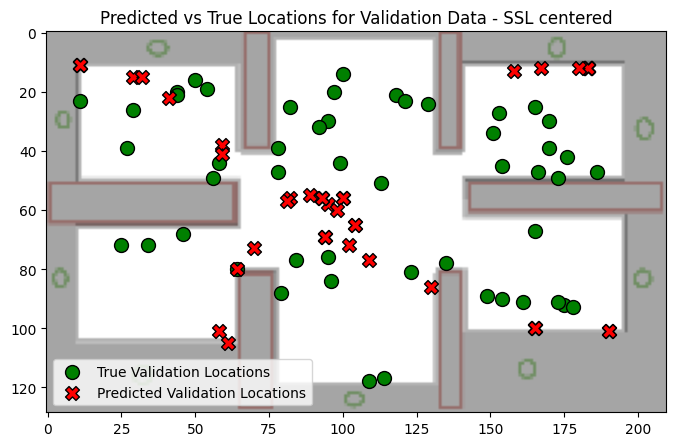

In [585]:
# Predict locations for the validation signal data
predicted_locations_validation = matcher.predict(validation_signal_data)

# Plot the predicted and true locations for the validation data on the layout
plt.figure(figsize=(8, 8))
plt.imshow(area_graph.polygon_mask, cmap='gray', alpha=0.5)
plt.imshow(area_graph.image, alpha=0.3)

# Plot the true locations of the validation points
plt.scatter(validation_true_real_locations[:, 0], validation_true_real_locations[:, 1], color='green', s=100, label="True Validation Locations", marker='o', edgecolor='black')

# Plot the predicted locations of the validation points
plt.scatter(predicted_locations_validation[:, 0], predicted_locations_validation[:, 1], color='red', s=100, label="Predicted Validation Locations", marker='X', edgecolor='black')

plt.legend()
plt.title("Predicted vs True Locations for Validation Data - SSL centered")
plt.show()

# regressor

In [526]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.linear_model import Ridge

class SSLRegressor:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.regressor = Ridge(alpha=alpha)
        self.fitted = False

    def fit(self, signal_graph, layout_graph, labeled_indices):
        """
        Train a regressor from signal embedding → real (x, y) layout points
        using only the labeled data.
        """
        self.signal_graph = signal_graph
        self.layout_graph = layout_graph
        self.labeled_indices = labeled_indices

        signal_embedding = signal_graph.get_embedding()
        layout_points = np.array(layout_graph.get_points())

        # Prepare training data: use only labeled indices
        X_train = signal_embedding[labeled_indices]
        y_train = layout_points[labeled_indices]

        # Fit regression model
        self.regressor.fit(X_train, y_train)
        self.fitted = True

    def predict(self, new_signal_vectors):
        """
        Predict (x, y) locations for new signal vectors.
        Steps:
        1. Embed new signal vectors using kernel projection.
        2. Apply learned regression model to predict layout coordinates.
        """
        if not self.fitted:
            raise ValueError("Must call .fit() before .predict()")

        # Embed new signals using kernel projection
        raw_signal_data = self.signal_graph.signal_data
        signal_embedding_all = self.signal_graph.get_embedding()

        D = cdist(new_signal_vectors, raw_signal_data)
        sigma = np.median(np.sort(D, axis=1)[:, self.signal_graph.k_nearest - 1])
        K = np.exp(-D**2 / sigma**2)
        new_signal_embedded = (K @ signal_embedding_all) / K.sum(axis=1, keepdims=True)

        # Predict using trained regressor
        predicted_xy = self.regressor.predict(new_signal_embedded)
        return predicted_xy


In [530]:
# Assuming you have already run the cells to create:
# - area_graph (PhysicalLayoutGraph built on all random_points)
# - signals (np.ndarray of signals for all random_points)
# - signal_graph (SignalGraph built on all signals)
# - points_with_signals_df (pd.DataFrame combining random_points and signals)

# Define labeled indices
labeled_indices = [i for i in range(100)] # Use the first 20 points for fitting

# Initialize and fit the matcher using the pre-built graphs and labeled indices
matcher = SSLRegressor()
matcher.fit(signal_graph,area_graph, labeled_indices)

In [531]:
# Define validation indices (e.g., indices from 20 to 29)
# Make sure these indices are not in labeled_indices
validation_indices = list(range(100, 150))

# Important: Add a check to ensure validation_indices do not overlap with labeled_indices
if any(i in labeled_indices for i in validation_indices):
    raise ValueError("Validation indices overlap with labeled indices.")

# Extract signal data and true layout locations for validation points
validation_data = points_with_signals_df.iloc[validation_indices].copy()
validation_signal_data = validation_data.drop(['x', 'y'], axis=1).values
validation_true_real_locations = validation_data[['x', 'y']].values

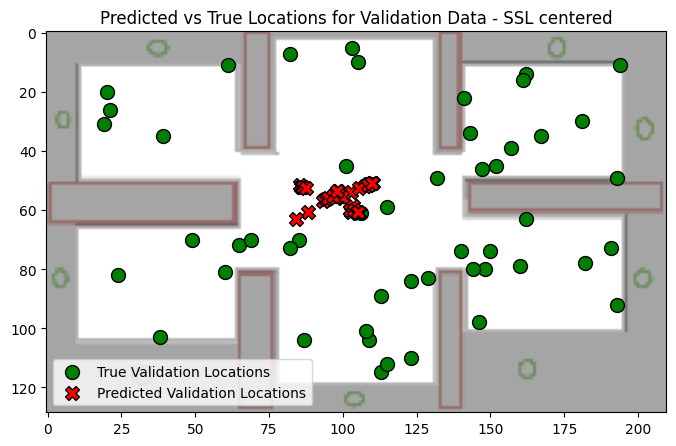

In [532]:
# Predict locations for the validation signal data
predicted_locations_validation = matcher.predict(validation_signal_data)

# Plot the predicted and true locations for the validation data on the layout
plt.figure(figsize=(8, 8))
plt.imshow(area_graph.polygon_mask, cmap='gray', alpha=0.5)
plt.imshow(area_graph.image, alpha=0.3)

# Plot the true locations of the validation points
plt.scatter(validation_true_real_locations[:, 0], validation_true_real_locations[:, 1], color='green', s=100, label="True Validation Locations", marker='o', edgecolor='black')

# Plot the predicted locations of the validation points
plt.scatter(predicted_locations_validation[:, 0], predicted_locations_validation[:, 1], color='red', s=100, label="Predicted Validation Locations", marker='X', edgecolor='black')

plt.legend()
plt.title("Predicted vs True Locations for Validation Data - SSL centered")
plt.show()

# Embedding to Embedding Calibration

In [274]:
class ManifoldMatcherEmbedding:
    def __init__(self):
        self.fitted = False

    def fit(self, layout_graph, signal_graph, labeled_indices):
        """
        Calibrate signal to layout graph embeddings using centered least squares.
        """
        self.layout_graph = layout_graph
        self.signal_graph = signal_graph

        phi_A = layout_graph.get_embedding()[labeled_indices]
        phi_S = signal_graph.get_embedding()[labeled_indices]

        # Linear calibration from layout to signal embedding
        self.C, _, _, _ = np.linalg.lstsq(phi_A, phi_S, rcond=None)

        # Calibrate the full layout embedding
        layout_full = layout_graph.get_embedding()
        self.calibrated_layout_embedding = layout_full @ self.C

        self.layout_embedding = layout_graph.get_embedding()
        self.signal_embedding = signal_graph.get_embedding()
        self.fitted = True

    def predict(self, predict_indices):
        """
        Predict (x, y) locations for new signal vectors based on calibrated embeddings.
        """
        if not self.fitted:
            raise ValueError("Must call .fit() before .predict()")
        
        phi_S_predicted = signal_graph.get_embedding()[predict_indices]
        A_embedded = self.layout_graph.get_embedding()
        dists = cdist(A_embedded, phi_S_predicted)
        min_dists_indices = np.argmin(dists, axis=0)
        return np.array(self.layout_graph.get_points())[min_dists_indices]

In [275]:
# Assuming you have already run the cells to create:
# - area_graph (PhysicalLayoutGraph built on all random_points)
# - signals (np.ndarray of signals for all random_points)
# - signal_graph (SignalGraph built on all signals)
# - points_with_signals_df (pd.DataFrame combining random_points and signals)

# Define labeled indices
labeled_indices = [i for i in range(200)] # Use the first 20 points for fitting

# Initialize and fit the matcher using the pre-built graphs and labeled indices
matcher = ManifoldMatcherEmbedding()
matcher.fit(area_graph, signal_graph, labeled_indices)

In [276]:
validation_indices = list(range(200, 250))

if any(i in labeled_indices for i in validation_indices):
    raise ValueError("Validation indices overlap with labeled indices.")

# Extract signal data and true layout locations for validation points
validation_data = points_with_signals_df.iloc[validation_indices].copy()
# validation_signal_data = validation_data.drop(['x', 'y'], axis=1).values
validation_true_real_locations = validation_data[['x', 'y']].values

In [277]:
# Predict locations for the validation signal data
predicted_locations_x_y = matcher.predict(validation_indices)

In [278]:
predicted_locations_x_y

array([[126, 105],
       [129, 100],
       [108,  10],
       [120,   2],
       [108,   4],
       [ 24,  68],
       [112,   8],
       [108,  10],
       [112,   8],
       [129,  38],
       [161,  63],
       [ 18,  94],
       [108,   4],
       [177,  62],
       [112,   8],
       [177,  62],
       [ 27,  72],
       [112,   8],
       [129,  38],
       [108,  10],
       [146,  88],
       [129, 100],
       [ 11,  35],
       [112,   8],
       [ 11,  13],
       [ 11,  13],
       [ 63, 102],
       [112,   8],
       [112,   8],
       [ 17,  74],
       [119,  16],
       [126, 105],
       [119,  16],
       [112,   8],
       [154,  63],
       [119,  16],
       [ 15,  47],
       [161,  63],
       [112,   8],
       [112,   8],
       [126, 105],
       [ 68,  61],
       [177,  62],
       [ 23,  66],
       [146,  88],
       [ 15,  47],
       [ 15,  47],
       [161,  63],
       [119,  16],
       [112,   8]])

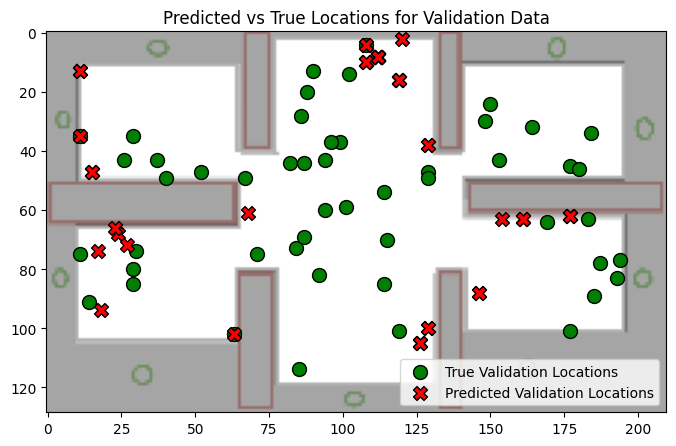

In [279]:
# Plot the predicted and true locations for the validation data on the layout
plt.figure(figsize=(8, 8))
plt.imshow(area_graph.polygon_mask, cmap='gray', alpha=0.5)
plt.imshow(area_graph.image, alpha=0.3)

# Plot the true locations of the validation points
plt.scatter(validation_true_real_locations[:, 0], validation_true_real_locations[:, 1], color='green', s=100, label="True Validation Locations", marker='o', edgecolor='black')

# Plot the predicted locations of the validation points
plt.scatter(predicted_locations_x_y[:, 0], predicted_locations_x_y[:, 1], color='red', s=100, label="Predicted Validation Locations", marker='X', edgecolor='black')

plt.legend()
plt.title("Predicted vs True Locations for Validation Data")
plt.show()